In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

from tqdm import tqdm

In [127]:
from AFML_module.dataset_utilities import (get_instrument_attributes, 
                                           form_dollar_bars, 
                                           form_time_bars,
                                           form_vol_bars,
                                           reduce_to_active_symbols, 
                                           apply_roll_factors)

from AFML_module.triple_barrier_utilities import get_daily_rolling_volatility

from AFML_module.cusum_filter import apply_cusum_filter

In [14]:
def JB_plotter(rolled_bars):
    result = []
    for n in range(1,100_000):
        data = rolled_bars["close"][::n].diff(1).dropna()
        if data.shape[0] > 100:
            jb_stat, p_value, skewness, kurtosis = jarque_bera(data)
            result.append([jb_stat, p_value, skewness, kurtosis])
        else:
            break
                        
    return result


In [3]:
from AFML_module.config import RAW_DATA_DIR

data = pd.read_parquet(RAW_DATA_DIR/"sp_emini_data.parquet", engine="pyarrow")
instrument_frame = pd.read_parquet(RAW_DATA_DIR/"instrument_frame.parquet", engine="pyarrow")

# Exercises

### 2.1 
On a series of E-mini S&P 500 futures tick data...

(a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.

(b) Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces
the most stable weekly count? Why?

(c) Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

(e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

### Time Bars

In [113]:
# Form 1 minute duration time bars for all instruments in frame
time_bars = form_time_bars(data, duration="1 min", sort=False) 

# Reduce to instruments expiring on soonest IMM dates
active_only_time_bars = reduce_to_active_symbols(time_bars, instrument_frame) # 

# Compute and apply roll factors
rolled_time_bars = apply_roll_factors(active_only_time_bars, sort=False)


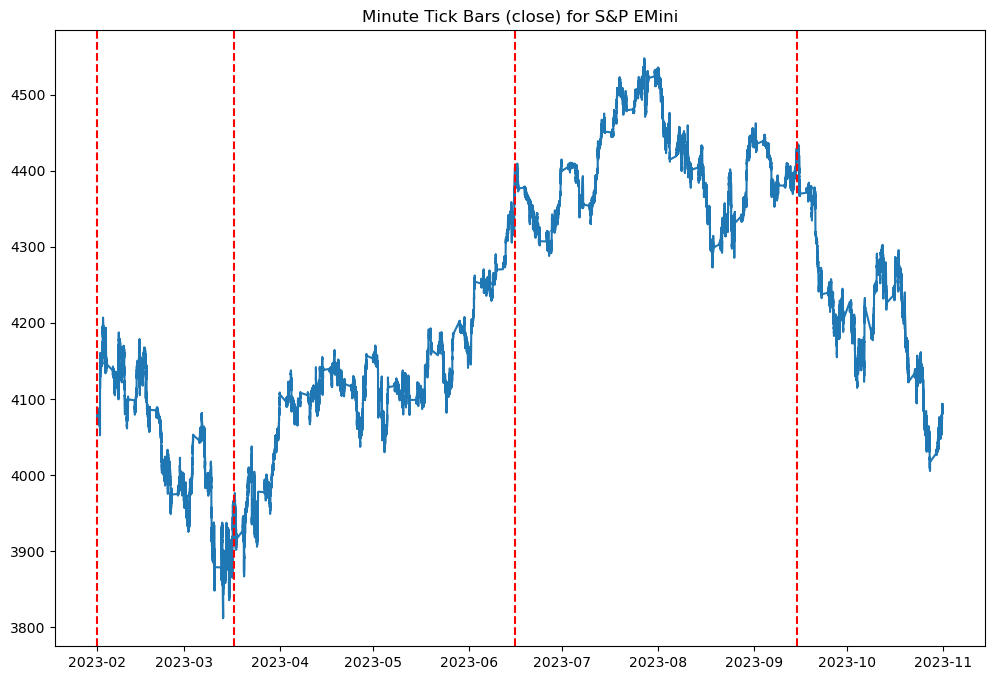

In [117]:
# as a check that we have rolled correctly, plot the time bars and roll dates and check 
# for continuity. 

plt.figure(figsize=(12, 8))

plt.plot(rolled_time_bars["first transaction"], rolled_time_bars["close"])

for time in rolled_time_bars[rolled_time_bars["Factor"]!=rolled_time_bars["Factor"].shift(1)]["first transaction"]:
    plt.axvline(time, color='red', linestyle='--', linewidth=1.5, label="Event")
    
plt.title("Minute Tick Bars (close) for S&P EMini");

Text(0, 0.5, 'Log JB Stat')

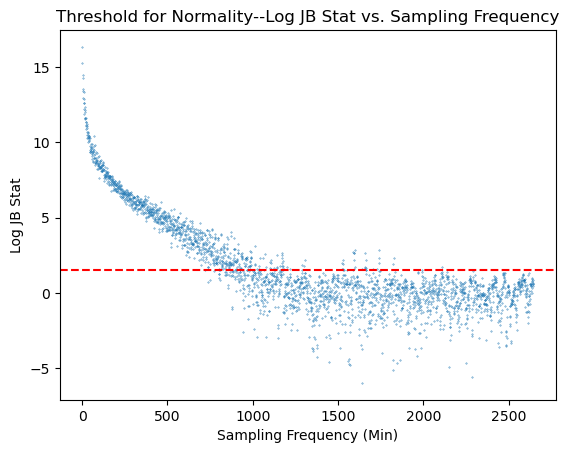

In [18]:
# Downsample time bars and compute close to close price changes; plot
# JB test statistic understand where we cannot reject normality at the 
# 10% significance level

result = JB_plotter(rolled_time_bars)

plt.scatter(np.arange(1, len(result)+1), np.log([r[0] for r in result]), s=0.1)
plt.axhline(y=np.log(4.605), color='r', linestyle='--', label="10% significance level") # 10% p-value

plt.title("Threshold for Normality--Log JB Stat vs. Sampling Frequency")
plt.xlabel("Sampling Frequency (Min)")
plt.ylabel("Log JB Stat")

In [42]:
# Conclude that we cannot outright reject the null hypothesis that 
# the data is normal (at 10% significance level) if sampling 
# frequency is ~1250 minutes = 21 hours

# We check to confirm whether the data at this sampling frequency looks 
# normal; it does by eye. The tails are still quite fat though;
# in these conventions are normal distribution has kurtosis 0 whereas
# this empircal distribution has kurtosis ~ 3.3

In [75]:
time_bars = form_time_bars(data, duration="1300Min", sort=False)
active_only_time_bars = reduce_to_active_symbols(time_bars, instrument_frame)
rolled_time_bars = apply_roll_factors(active_only_time_bars, sort=False)

,jb_stat,p_value,skewness,kurtosis
0,3.258826,0.196045,-0.249522,3.260004


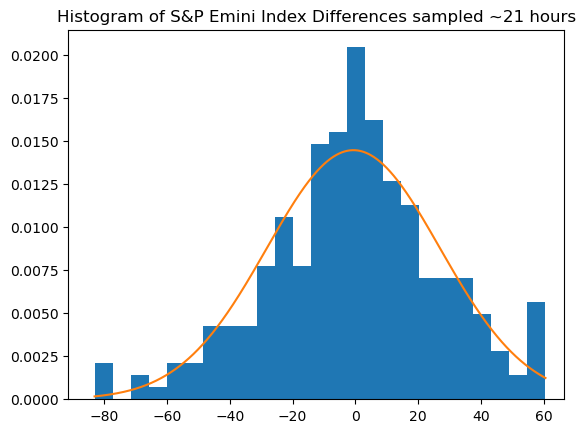

In [76]:
diff_data = rolled_time_bars["close"].diff(1).dropna()

mean, std = norm.fit(diff_data)
grid = np.linspace(diff_data.min(), diff_data.max(), 10_000)

plt.hist(diff_data, bins=25, density=True);
plt.plot(grid, norm.pdf(grid, loc=mean, scale=std))
plt.xlim(diff_data.min()*1.1, diff_data.max()*1.1);
plt.title("Histogram of S&P Emini Index Differences sampled ~21 hours")

jb_stat, p_value, skewness, kurtosis = jarque_bera(diff_data)
pd.DataFrame([[jb_stat, p_value, skewness, kurtosis]], 
                  columns=["jb_stat", "p_value", "skewness", "kurtosis"])


Std:  0.8828857114526092 Bars per week


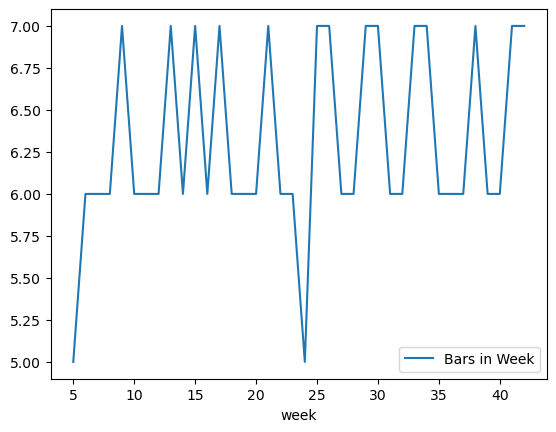

In [77]:
# Weekly count of time bars. This number is very stable, by definition; 
 

rolled_time_bars["week"] = rolled_time_bars["first transaction"].dt.isocalendar().week
print("Std: ", rolled_time_bars.groupby("week").count()[["symbol"]].rename(columns = {"symbol":"Bars in Week"}).std().values[0], "Bars per week")
rolled_time_bars.groupby("week").count()[["symbol"]].rename(columns = {"symbol":"Bars in Week"})[:-2].plot();


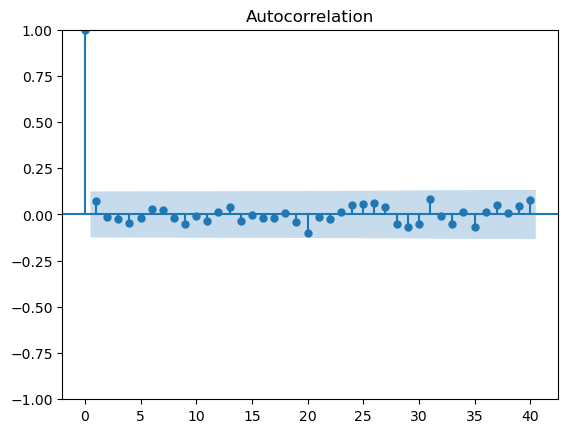

In [78]:
# There is hardly any serial autocorrelation in returns 
sm.graphics.tsa.plot_acf(rolled_time_bars["return"], lags=40);

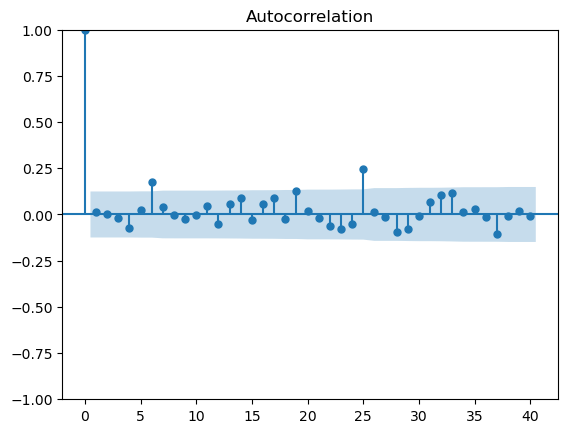

In [80]:
# There is however autocorrelation in the square of returns,
# indicating some volatility clustering
sm.graphics.tsa.plot_acf(rolled_time_bars["return"]**2, lags=40);

### Volume Bars

Text(0, 0.5, 'Log JB Stat')

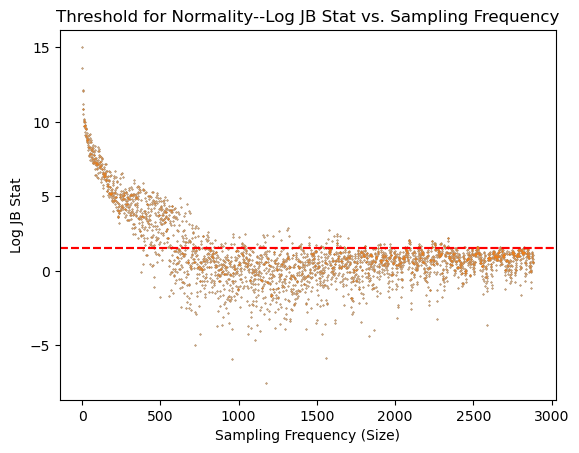

In [91]:
# Form bars at 1000 size transacted
vol_bars = form_vol_bars(data, 1_000, sort=True)
active_only_vol_bars = reduce_to_active_symbols(vol_bars, instrument_frame)
rolled_vol_bars = apply_roll_factors(active_only_vol_bars, sort=False)

result = JB_plotter(rolled_vol_bars)

plt.scatter(np.arange(1, len(result)+1), np.log([r[0] for r in result]), s=0.1)
plt.axhline(y=np.log(4.605), color='r', linestyle='--') # 10% p-value

plt.scatter(np.arange(1, len(result)+1), np.log([r[0] for r in result]), s=0.1)
plt.axhline(y=np.log(4.605), color='r', linestyle='--', label="10% significance level") # 10% p-value

plt.title("Threshold for Normality--Log JB Stat vs. Sampling Frequency")
plt.xlabel("Sampling Frequency (Size)")
plt.ylabel("Log JB Stat")

# suggests we should sample every ~800*1000 transacted size to not
# outright reject normality at the 10% level via the JB test.
# this is sampling roughly every 11 hours on average.
# The empircal distribution looks more fairly normal, but the kurtosis
# is still high

In [95]:
vol_bars = form_vol_bars(data, 800*1000, sort=True)
active_only_vol_bars = reduce_to_active_symbols(vol_bars, instrument_frame)
rolled_vol_bars = apply_roll_factors(active_only_vol_bars, sort=False)

In [96]:
mean_hours = (rolled_vol_bars['last transaction'] - rolled_vol_bars['first transaction']).dt.seconds.mean()/60/60
std_hours = (rolled_vol_bars['last transaction'] - rolled_vol_bars['first transaction']).dt.seconds.std()/60/60
print(f"one bar is roughly {np.round(mean_hours, 2)} hours, plus/minus {np.round(std_hours, 2)} hours")

one bar is roughly 11.74 hours, plus/minus 7.34 hours


,jb_stat,p_value,skewness,kurtosis
0,4.495556,0.105634,0.233315,3.28338


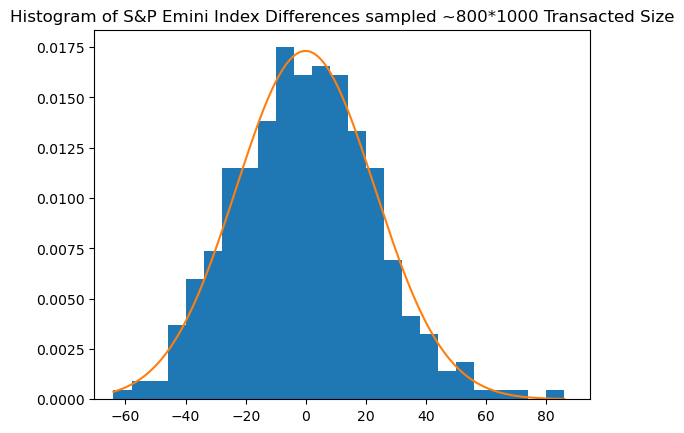

In [98]:
diff_data = rolled_vol_bars["close"].diff(1).dropna()

mean, std = norm.fit(diff_data)
grid = np.linspace(diff_data.min(), diff_data.max(), 10_000)

plt.hist(diff_data, bins=25, density=True);
plt.plot(grid, norm.pdf(grid, loc=mean, scale=std))
plt.xlim(diff_data.min()*1.1, diff_data.max()*1.1);
plt.title("Histogram of S&P Emini Index Differences sampled ~800*1000 Transacted Size")

jb_stat, p_value, skewness, kurtosis = jarque_bera(diff_data)
pd.DataFrame([[jb_stat, p_value, skewness, kurtosis]], 
                  columns=["jb_stat", "p_value", "skewness", "kurtosis"])


Std:  2.3357588126279714 bars per week


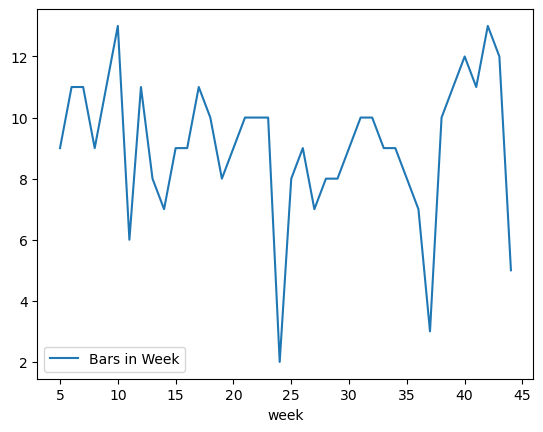

In [102]:
# weekly count of bars
rolled_vol_bars["week"] = rolled_vol_bars["first transaction"].dt.isocalendar().week
print("Std: ", rolled_vol_bars.groupby("week").count()[["symbol"]].rename(columns = {"symbol":"Bars in Week"}).std().values[0], "bars per week")
rolled_vol_bars.groupby("week").count()[["symbol"]].rename(columns = {"symbol":"Bars in Week"}).plot();

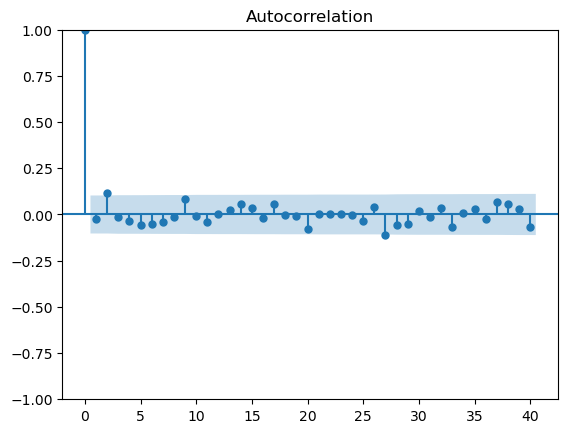

In [104]:
# Very little autocorrelation
sm.graphics.tsa.plot_acf(rolled_vol_bars["return"], lags=40);

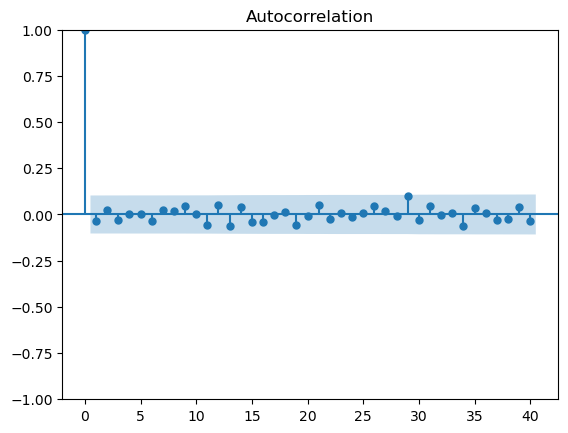

In [107]:
# Very little autocorrelation of square; 
# indicates that vol clustering has been likely "smoothed out"
sm.graphics.tsa.plot_acf(rolled_vol_bars["return"]**2, lags=40);

### Dollar Bars

Text(0, 0.5, 'Log JB Stat')

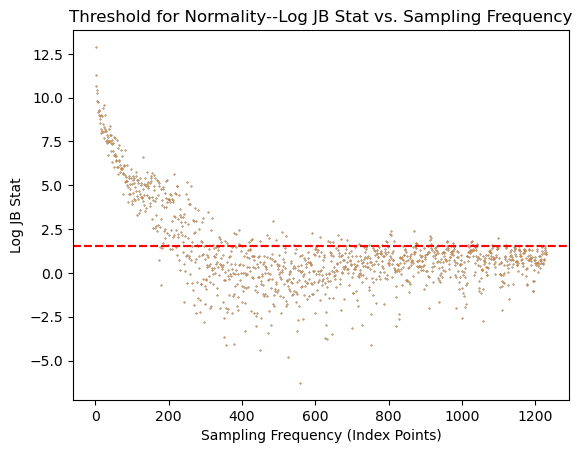

In [288]:
# Form bars at 10_000_000 index points transacted
dollar_bars = form_dollar_bars(data, 10_000_000, sort=True)
active_only_dollar_bars = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled_dollar_bars = apply_roll_factors(active_only_dollar_bars, sort=False)

result = JB_plotter(rolled_dollar_bars)

plt.scatter(np.arange(1, len(result)+1), np.log([r[0] for r in result]), s=0.1)
plt.axhline(y=np.log(4.605), color='r', linestyle='--') # 10% p-value

plt.scatter(np.arange(1, len(result)+1), np.log([r[0] for r in result]), s=0.1)
plt.axhline(y=np.log(4.605), color='r', linestyle='--', label="10% significance level") # 10% p-value

plt.title("Threshold for Normality--Log JB Stat vs. Sampling Frequency")
plt.xlabel("Sampling Frequency (Index Points)")
plt.ylabel("Log JB Stat")


In [62]:
# suggests we should sample every ~300*10_000_000 index points to not
# outright reject normality at the 10% level via the JB test.
# this is sampling roughly every 10 hours on average.
# The empircal distribution looks more fairly normal, but the kurtosis
# is still high

In [289]:
dollar_bars = form_dollar_bars(data, 300*10_000_000, sort=True)
active_only_dollar_bars = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled_dollar_bars = apply_roll_factors(active_only_dollar_bars, sort=False)

In [290]:
mean_hours = (rolled_dollar_bars['last transaction'] - rolled_dollar_bars['first transaction']).dt.seconds.mean()/60/60
std_hours = (rolled_dollar_bars['last transaction'] - rolled_dollar_bars['first transaction']).dt.seconds.std()/60/60
print(f"one bar is roughly {np.round(mean_hours, 2)} hours, plus/minus {np.round(std_hours, 2)} hours")


one bar is roughly 10.43 hours, plus/minus 7.18 hours


,jb_stat,p_value,skewness,kurtosis
0,1.004265,0.605239,0.096476,2.853669


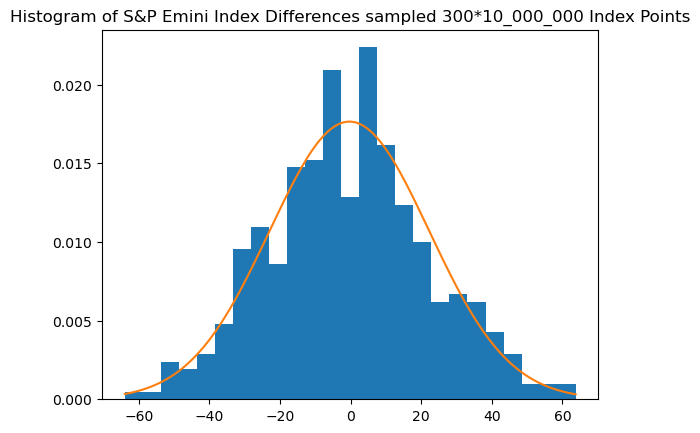

In [291]:
diff_data = rolled_dollar_bars["close"].diff(1).dropna()

mean, std = norm.fit(diff_data)
grid = np.linspace(diff_data.min(), diff_data.max(), 10_000)

plt.hist(diff_data, bins=25, density=True);
plt.plot(grid, norm.pdf(grid, loc=mean, scale=std))
plt.xlim(diff_data.min()*1.1, diff_data.max()*1.1);
plt.title("Histogram of S&P Emini Index Differences sampled 300*10_000_000 Index Points")

jb_stat, p_value, skewness, kurtosis = jarque_bera(diff_data)
pd.DataFrame([[jb_stat, p_value, skewness, kurtosis]], 
                  columns=["jb_stat", "p_value", "skewness", "kurtosis"])


Std:  2.6428422928005726 bars per week


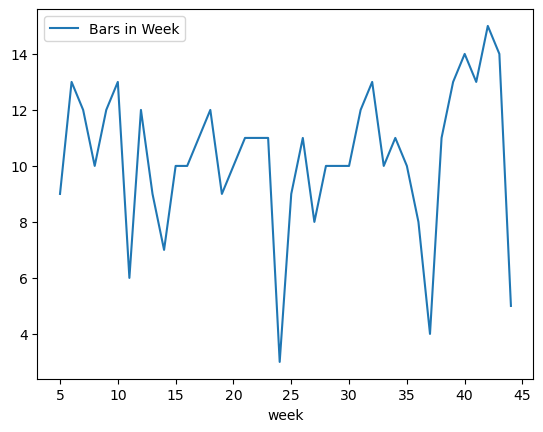

In [83]:
# weekly count of bars; less stable than time bars

rolled_dollar_bars["week"] = rolled_dollar_bars["first transaction"].dt.isocalendar().week
print("Std: ", rolled_dollar_bars.groupby("week").count()[["symbol"]].rename(columns = {"symbol":"Bars in Week"}).std().values[0], "bars per week")
rolled_dollar_bars.groupby("week").count()[["symbol"]].rename(columns = {"symbol":"Bars in Week"}).plot();

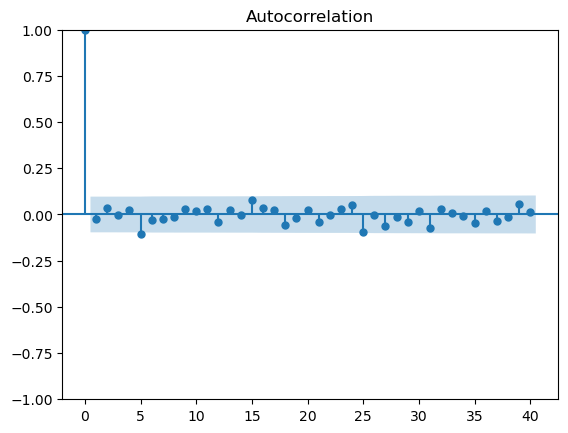

In [84]:
# There is very little autocorrelation
sm.graphics.tsa.plot_acf(rolled_dollar_bars["return"], lags=40);

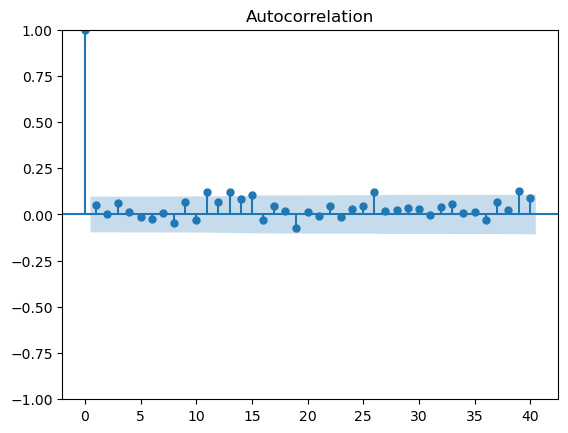

In [86]:
# The correlation of squared returns is also smaller, suggesting
# this information based sampling has "smoothed out" the volatility
# clustering

sm.graphics.tsa.plot_acf(rolled_dollar_bars["return"]**2, lags=40);

Tick bars, then volume bars, then dollar bars approach normality faster on average. To have insufficient evidence to reject normalilty via Jarque Berra test, we sample every

 - ~21 hours for tick bars
 - ~11 hours for volume bars
 - ~10 hours for dollar bars

This is handwavy though, since the JB statistic plots are noisy.  Also, even when we fail to reject the null hypothesis, the histograms certainly do not look normal; they can have significant skew and kurtosis.

Weekly count of bars is most stable for time bars, as it must be by definition. Roughly same stability for volume bars and dollar bars

All bars have hardly any auto correlation in their returns. However, volume bars and dollar bars have less autocorrelation in the square of returns, suggesting the information based sampling has "smooth out" the volatility clustering


### 2.4

Form E-mini S&P 500 futures dollar bars:
    
(a) Compute Bollinger bands of width 5% around a rolling moving average.
Count how many times prices cross the bands out (from within the bands
to outside the bands).

(b) Now sample those bars using a CUSUM filter, where {yt} are returns and
h = 0.05. How many samples do you get?

(c) Compute the rolling standard deviation of the two sampled series. Which
one is least heteroscedastic? What is the reason for these results?

In [402]:
dollar_bars = form_dollar_bars(data, 200*10_000_000, sort=True)
active_only_dollar_bars = reduce_to_active_symbols(dollar_bars, instrument_frame)
rolled_dollar_bars = apply_roll_factors(active_only_dollar_bars, sort=False)

Text(0.5, 0, 'Dollar Bar')

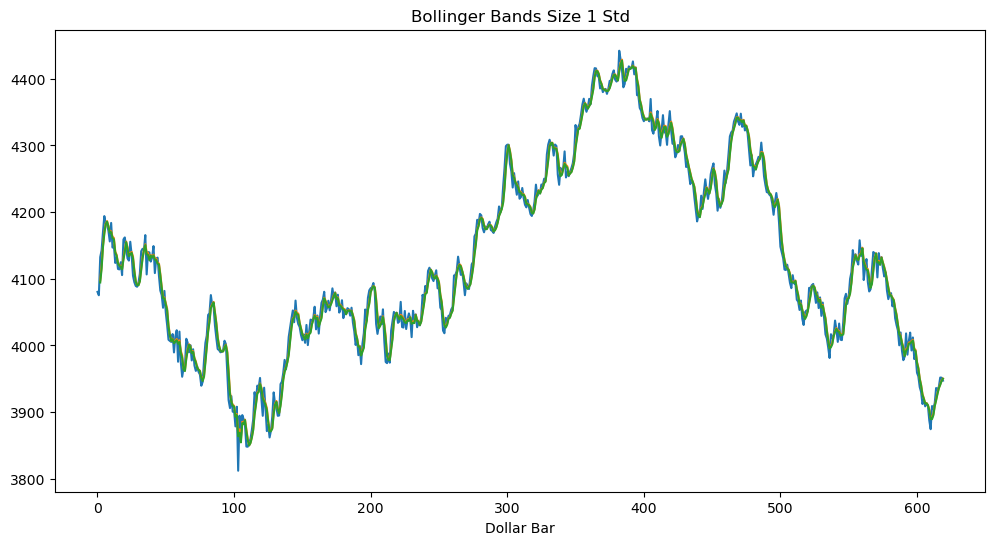

In [403]:
# Use Bollinger Bands of Width 1 std.

bollinger_thresh = 3 # lookback period of ~10 dollar bars ~ 100 hours

rolling_mean = rolled_dollar_bars["close"].rolling(window=bollinger_thresh).mean()
rolling_std = rolled_dollar_bars["close"].rolling(window=bollinger_thresh).std()

rolled_dollar_bars["upper bollinger"] = rolling_mean + 0.05*rolling_std
rolled_dollar_bars["lower bollinger"] = rolling_mean - 0.05*rolling_std

plt.figure(figsize=(12, 6))
plt.plot(rolled_dollar_bars["close"])
plt.plot(rolled_dollar_bars["upper bollinger"])
plt.plot(rolled_dollar_bars["lower bollinger"])

plt.title("Bollinger Bands Size 1 Std")
plt.xlabel("Dollar Bar")

In [404]:
# Compute the number of crossings
upper_diff_sign = np.sign(rolled_dollar_bars["upper bollinger"] - rolled_dollar_bars["close"])
lower_diff_sign = np.sign(rolled_dollar_bars["close"] - rolled_dollar_bars["lower bollinger"])

upper_crossings = np.where((upper_diff_sign == 1) & (upper_diff_sign.shift(1) == -1))[0]
lower_crossings = np.where((lower_diff_sign == 1) & (lower_diff_sign.shift(1) == -1))[0]

crossings = np.sort(np.concatenate([upper_crossings, lower_crossings]))
print(f"Crossings: {crossings.shape[0]}")

Crossings: 229


Text(0.5, 0, 'Bar Number')

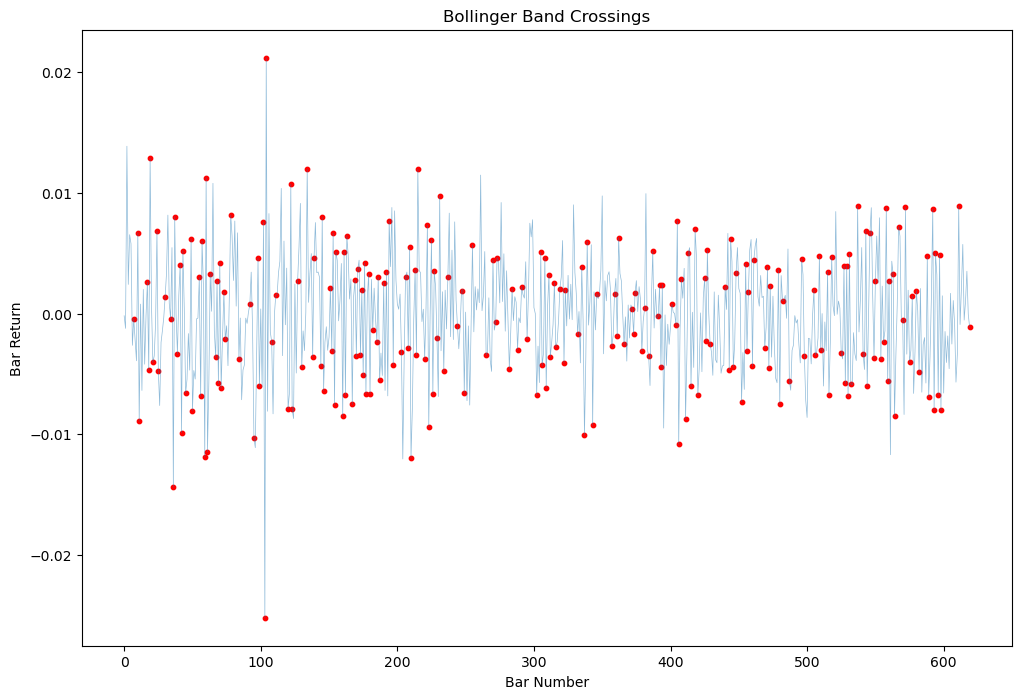

In [405]:
# It is helpful to plot the events in "return space", to get a sense
# of what kind of kind of events the Bollinger Band trigger samples

plt.figure(figsize=(12, 8))
plt.plot(rolled_dollar_bars["return"], linewidth=0.5, alpha=0.5)
plt.scatter(crossings, rolled_dollar_bars.loc[crossings]["return"], s=10, color="red")
plt.title("Bollinger Band Crossings")
plt.ylabel("Bar Return")
plt.xlabel("Bar Number")

In [406]:
events = apply_cusum_filter(rolled_dollar_bars, 0.01)
print(f"Events: {len(events)}")

Events: 170


Text(0.5, 0, 'Bar Number')

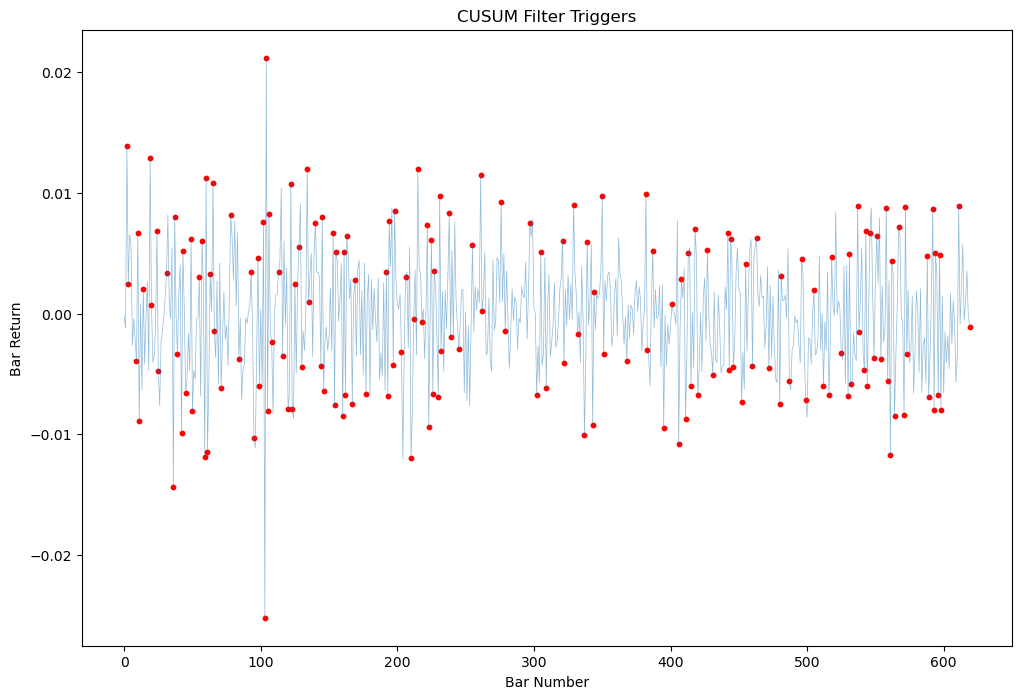

In [407]:
plt.figure(figsize=(12, 8))
plt.plot(rolled_dollar_bars["return"], linewidth=0.5, alpha=0.5)
plt.scatter(events, rolled_dollar_bars.loc[events]["return"], s=10, color="red")

plt.title("CUSUM Filter Triggers")
plt.ylabel("Bar Return")
plt.xlabel("Bar Number")

Text(0.5, 1.0, 'Rolling Std of Bar Returns Sampled from Bollinger Band Crossings')

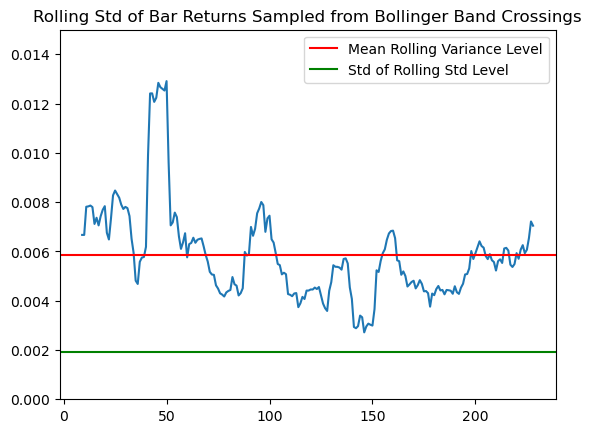

In [411]:
# Now we compare the rolling standard devations for each sampled series
cross_returns = rolled_dollar_bars.iloc[crossings]["return"]

rolling_std = cross_returns.rolling(window=10).std()

plt.plot(rolling_std.reset_index()["return"])
plt.axhline(y=rolling_std.mean(), color="red", label="Mean Rolling Variance Level")
plt.axhline(y=rolling_std.std(), color="green", label="Std of Rolling Std Level")
plt.legend()

plt.ylim(0, 0.015)

plt.title("Rolling Std of Bar Returns Sampled from Bollinger Band Crossings")

Text(0.5, 1.0, 'Rolling Std of Bar Returns Sampled from CUSUM Band Crossings')

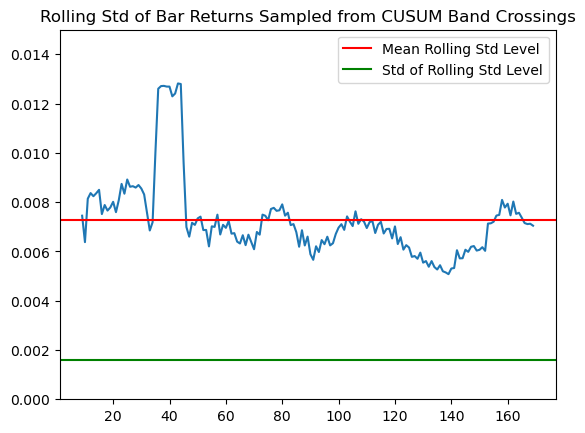

In [412]:
cross_return = rolled_dollar_bars.iloc[events]["return"]

rolling_std = cross_return.rolling(window=10).std()

plt.plot(rolling_std.reset_index()["return"])
plt.axhline(y=rolling_std.mean(), color="red", label="Mean Rolling Std Level")
plt.axhline(y=rolling_std.std(), color="green", label="Std of Rolling Std Level")
plt.legend()

plt.legend()

plt.ylim(0, 0.015)

plt.title("Rolling Std of Bar Returns Sampled from CUSUM Band Crossings")

First, events triggering the CUSUM filter happen less often than events defined by Bollinger Band crossings. This is because Bollinger Bands tend to cut through the series, and thus sample roughly the same price over and over. On the other hand, the CUSUM is reset after it triggers, and so tends to not sample points right next to each other.

The heteroscedasticity of the bar returns sampled by the CUSUM filter is lower than for bars sampled by the Bollinger Bands. This is by design; between sampled points, the bar return can only change by roughly plus/minus the CUSUM cutoff. However, the bar return can change arbitrarily between points sampled by the Bollinger Bands.  Therefore the former has a lower variance. 

This is evident from the respective plots of rolling standard deviation. For the CUSUM sampled bars, it is much more concentrated around one value.

### 2.5

Using the bars from exercise 4:

(a) Sample bars using the CUSUM filter, where {yt} are absolute returns and
h = 0.05.

(b) Compute the rolling standard deviation of the sampled bars.

(c) Compare this result with the results from exercise 4. What procedure delivered the least heteroscedastic sample? Why?

In [413]:
rolled_dollar_bars_abs_return = rolled_dollar_bars.copy()
rolled_dollar_bars_abs_return["return"] = np.abs(rolled_dollar_bars_abs_return["return"])

events = apply_cusum_filter(rolled_dollar_bars_abs_return, 0.01)

Text(0.5, 1.0, 'Rolling Std of Bar Abs Returns Sampled from CUSUM Band Crossings on Abs Returns')

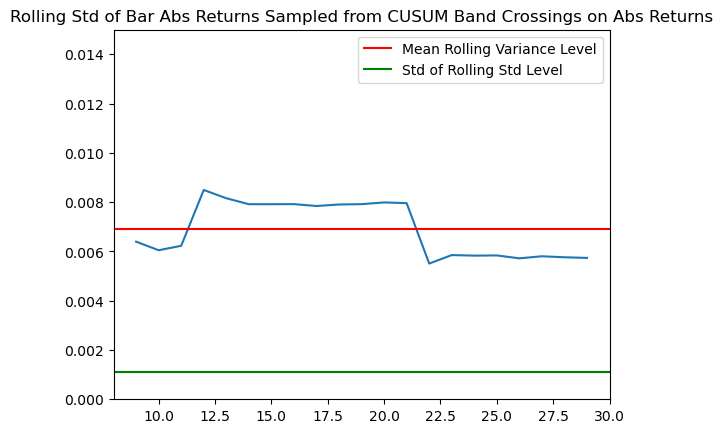

In [414]:
cross_return = rolled_dollar_bars_abs_return.iloc[events]["return"]

rolling_std = cross_return.rolling(window=10).std()

plt.plot(rolling_std.reset_index()["return"])
plt.axhline(y=rolling_std.mean(), color="red", label="Mean Rolling Variance Level")
plt.axhline(y=rolling_std.std(), color="green", label="Std of Rolling Std Level")
plt.legend()

plt.ylim(0, 0.015)

plt.legend()

plt.title("Rolling Std of Bar Abs Returns Sampled from CUSUM Band Crossings on Abs Returns")

The above procedure produced the least heteroscedastic sample.  Again this is intuitive; we've reduced the values that the absolute return can take between samplings, so the variance is lower.